# Detect freshness of fruits using PyTorch
<br>
<img src='https://upload.wikimedia.org/wikipedia/commons/9/96/Pytorch_logo.png'/>
<br>
Through this tutorial I will be giving a step by step guide to tackle a simple deep learning problem. In this notebook I will train a model to detect the freshness of the fruit and then use this model to create a simple app deployed on the web so that anyone and play with it. For the latter part, I have created a [github project](https://github.com/anshuls235/freshness-detector) and the app can be accessed through this [link](https://freshness-detector.herokuapp.com/).
<br><br>

### Now lets first train our model!!

# Importing the Libraries

In [1]:
#For accessing files
import os
import glob

#For Images
import cv2
import matplotlib.pyplot as plt
import numpy as np

#For checking progress
from tqdm import tqdm_notebook

import datetime

#PyTorch Packages
import torch
from torch.utils.data.dataset import Dataset
from torchvision import transforms
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn.functional as F
import torch.optim as optim
import torch.nn as nn

#ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Studying the data
Let's take a look at the data on which we will be training our data and the one on which we will be doing our predictions.

In [2]:
def get_image(path,transform=False):
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    if transform:
        img = transform(img)
    return img
def show_data(rows,cols,is_train=True,transform=False):
    if is_train:path = '/kaggle/input/fruits-fresh-and-rotten-for-classification/dataset/train/'
    else:path = '/kaggle/input/fruits-fresh-and-rotten-for-classification/dataset/test/'
    path = os.path.join(path,'*','*.png')
    img_paths = glob.glob(path)
    np.random.seed(0)
    img_paths = np.random.choice(img_paths,rows*cols)
    fig = plt.figure(figsize=(8,8),dpi=150)
    i = 1
    for r in range(rows):
        for c in range(cols):
            image_path = img_paths[i-1]
            if 'fresh' in image_path.split('/')[-2]:
                title = 'Fresh'
            else:
                title = 'Rotten'
            ax = fig.add_subplot(rows,cols,i)
            img = get_image(image_path,transform)
            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_title(title,fontsize=5)
            ax.imshow(img)
            i+=1
    return fig

## Training data

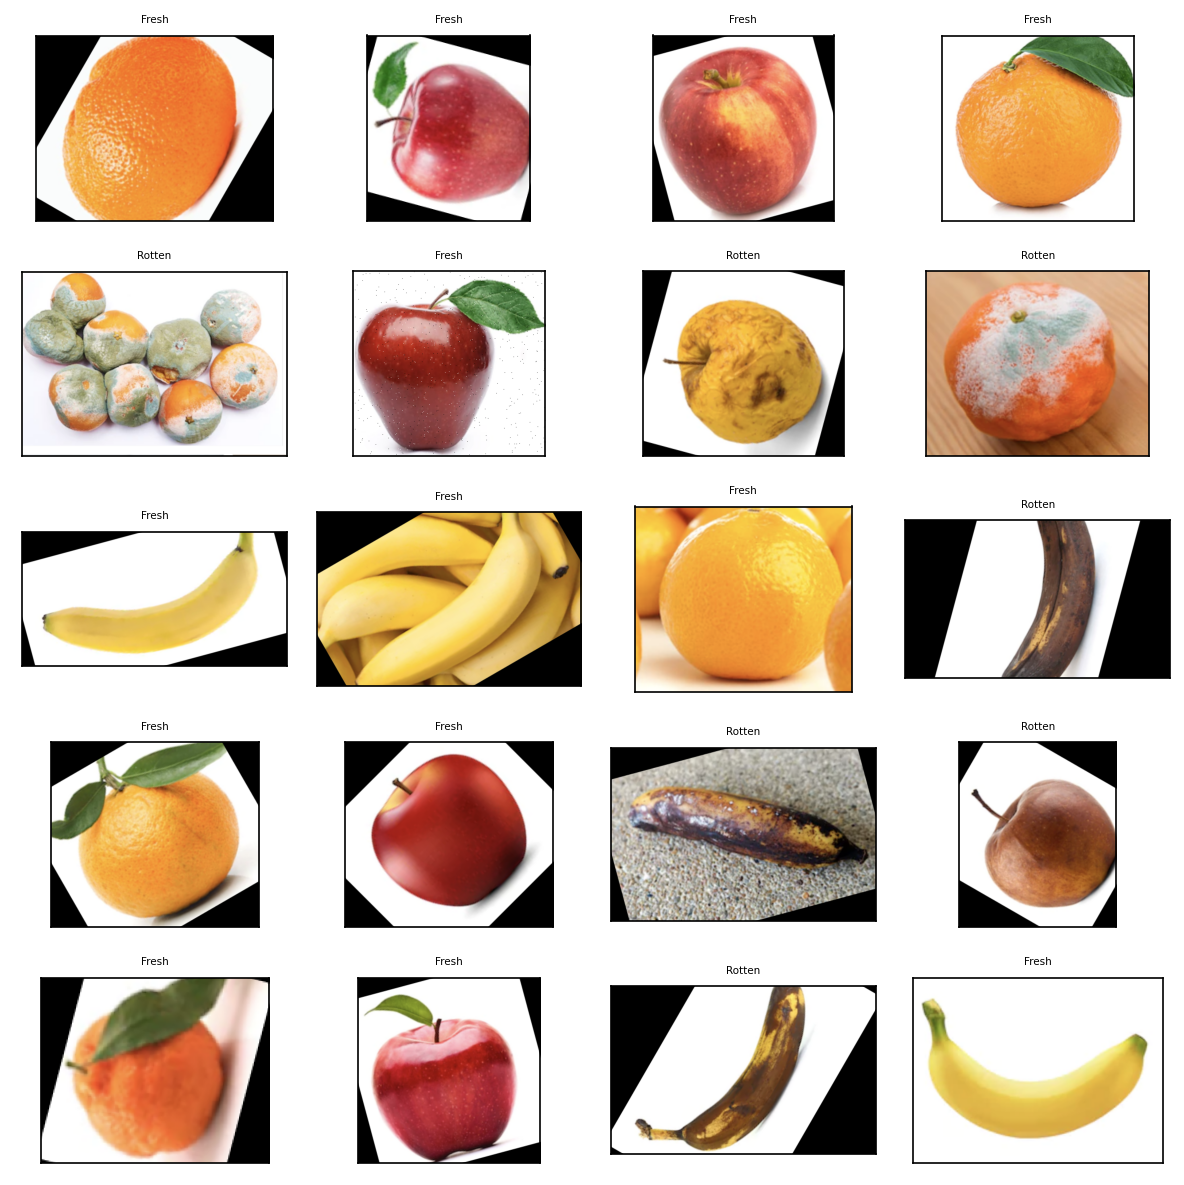

In [3]:
fig = show_data(5,4)
fig.tight_layout()

## Test Data
We already have the labels so that we can test our model's accuracy. Just showing the labels to show the images in test data.

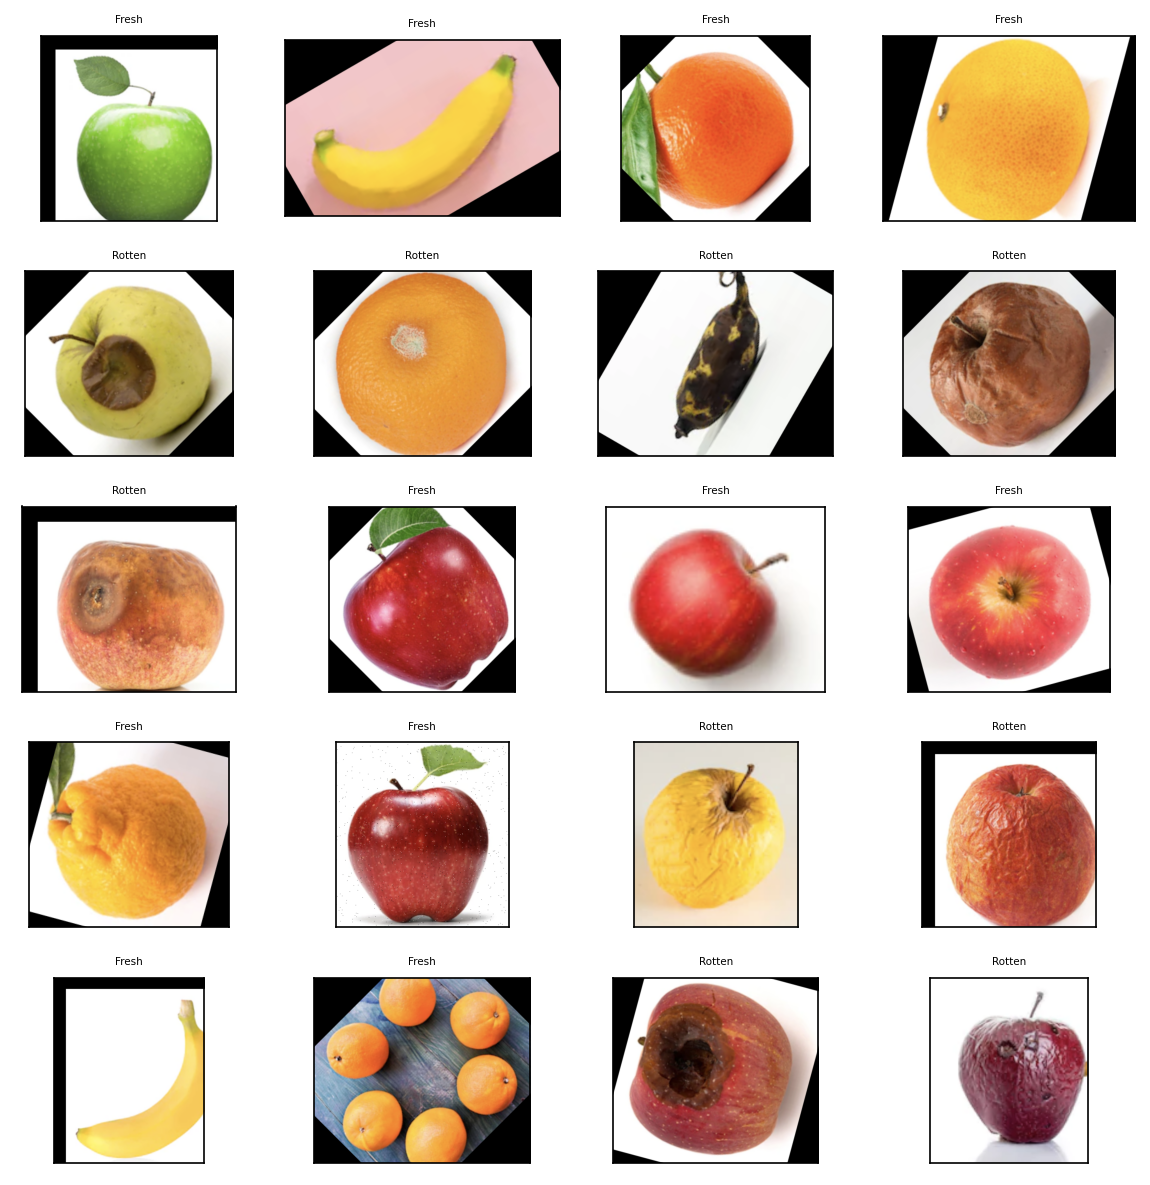

In [4]:
fig = show_data(5,4,is_train=False)
fig.tight_layout()

# PyTorch Datasets and Dataloaders
The dataset which is provided to us is just images in separate folders: `freshapples`,`freshbanana`,`freshoranges`,`rottenapples`,`rottenbanana` & `rottenoranges`. These folders are common subfolders in train and test folders.

A lot of effort in solving any machine learning problem goes in to preparing the data. PyTorch provides many tools to make data loading easy and hopefully, to make your code more readable.

## Custom Dataset
`torch.utils.data.Dataset` is an abstract class representing a dataset. The custom dataset should inherit Dataset and override the following methods:

- `__len__` so that len(dataset) returns the size of the dataset.
- `__getitem__` to support the indexing such that dataset[i] can be used to get ith sample

So, I'll be creating a custom dataset `FruitsDataset` which inherits Dataset class and overrides the above methods.

In [5]:
class FruitsDataset(Dataset):
    def __init__(self,path,classifier_type='Rotten',subset='train',transforms=None):
        self.subset = subset
        if self.subset == 'train':
            self.PATH = os.path.join(path,'train','*','*.png')
        elif self.subset == 'test':
            self.PATH = os.path.join(path,'test','*','*.png')
        self.data = glob.glob(self.PATH)
        self.height = 32
        self.width = 32
        self.labels = [] 
        if classifier_type == 'Rotten':
            classes = ['fresh','rotten']
            for fruit in self.data:
                if classes[0] in fruit.split('/')[-2]:
                    self.labels.append(0)
                else:
                    self.labels.append(1)
        else:
            classes = ['apple','banana','orange']
            for fruit in self.data:
                if classes[0] in fruit:
                    self.labels.append(0)
                elif classes[1] in fruit:
                    self.labels.append(1)
                else:
                    self.labels.append(2)
        self.transforms = transforms
      
    def __getitem__(self,index):
        img_path = self.data[index]
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        img = cv2.resize(img,(self.width,self.height))
        label = self.labels[index]
        if self.transforms is not None:
            img_as_tensor = self.transforms(img)
            if self.transforms is not None:
                return(img_as_tensor,label)
            return(img,label)
  
    def __len__(self):
        return(len(self.data))

## Transforms
One issue we can face is the samples are not of the same size. Most neural networks expect the images of a fixed size. Therefore, we will need to write some prepocessing code. Let’s create two transforms:

- `ToTensor`: to convert the numpy images to torch images (we need to swap axes).
- `Normalize`: so that the images have zero mean and one variance.

**Please Note: ** For rescaling the images to 32x32 size(This is the size I have chosen) I have used cv2. Instead, we can simply use `Rescale()` transform 

In [6]:
transformations = transforms.Compose([
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.7321, 0.6322, 0.5291),
                                                           (0.3302, 0.3432, 0.3701))
                                      ])
dataset = FruitsDataset('/kaggle/input/fruits-fresh-and-rotten-for-classification/dataset/',transforms = transformations)

Let's take a look at a random image from the dataset we have created. I have used permute function because images are usually represented as `Height x Width x #Channels` where #Channels is 3 for RGB images and 1 for grayscale images. While, pytorch tensors are represented as `#Channels x Height x Width`.

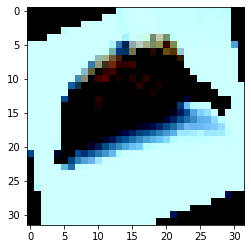

In [7]:
img_t, _ = dataset[1000]
img = img_t.permute(1,2,0)
plt.imshow(img);

You will be seeing a very distored image of a fruit. Its because of the transformations applied to have a common size for all the images. I have chosen such a small size for reducing the training time.

## DataLoaders
We can iterate over the created dataset with a simple `for` loop. However, we are losing a lot of features by using a simple `for` loop to iterate over the data. In particular, we are missing out on:

- Batching the data
- Shuffling the data
- Load the data in parallel using multiprocessing workers.

`torch.utils.data.DataLoader` is an iterator which provides all these features. I will create separate loaders for training and validation with sampling.

In [8]:
batch_size = 64
validation_split = .2
shuffle_dataset = True
random_seed= 42

# Creating data indices for training and validation splits:
dataset_size = len(dataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, 
                                           sampler=train_sampler)
validation_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                                sampler=valid_sampler)

# Training the Model
Let's redifine the `nn.Module` class to create our custom NN.

In [9]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3,16,kernel_size=3,padding=1)
        self.conv2 = nn.Conv2d(16,8,kernel_size=3,padding=1)
        self.fc1 = nn.Linear(8*8*8,32)
        self.fc2 = nn.Linear(32,2)
    def forward(self,x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)),2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)),2)
        out = out.view(-1,8*8*8)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

Lets check the number of parameters we have to train.

In [10]:
model = Net()
numel_list = [p.numel() for p in model.parameters()]
sum(numel_list), numel_list

(18090, [432, 16, 1152, 8, 16384, 32, 64, 2])

Confirm if we are training on GPU.

In [11]:
device = (torch.device('cuda') if torch.cuda.is_available()
  else torch.device('cpu'))
print(f"Training on device {device}.")

Training on device cpu.


Training loop

In [12]:
def training_loop(n_epochs,optimizer,model,loss_fn,train_loader):
    losss=[]
    train_loss=[]
    acc=[]
    for epoch in tqdm_notebook(range(1,n_epochs+1)):
        loss_train = 0.0
        for imgs, labels in train_loader:
            imgs = imgs.to(device=device)
            labels = labels.to(device=device)
            outputs = model(imgs)
            loss = loss_fn(outputs,labels)
            losss.append(loss)
            #get rid of gradients from last round
            optimizer.zero_grad()
            #performs backward step. Computes all the gradients
            loss.backward()
            #Updates the model
            optimizer.step()
            loss_train += loss.item()
        train_loss.append(loss_train) # append loss in train_loss
        print(train_loss)
        acc.append((loss_train/len(train_loader)))#append accoracy in acc list 
        print(loss_train/len(train_loader))
        print('{} Epoch {}, Training Loop {}'.format(
          datetime.datetime.now(), epoch, loss_train/len(train_loader)))
    return acc

model = Net().to(device=device) #was talking about this above
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()
acc_=training_loop(
  n_epochs = 5,
  optimizer = optimizer,
  model = model,
  loss_fn = loss_fn,
  train_loader = train_loader,
)

[86.78449803590775]
0.6334634893131952
2022-08-27 10:15:47.267566 Epoch 1, Training Loop 0.6334634893131952
[86.78449803590775, 69.83328574895859]
0.5097320127661211
2022-08-27 10:16:48.398281 Epoch 2, Training Loop 0.5097320127661211
[86.78449803590775, 69.83328574895859, 63.834814727306366]
0.4659475527540611
2022-08-27 10:17:49.325617 Epoch 3, Training Loop 0.4659475527540611
[86.78449803590775, 69.83328574895859, 63.834814727306366, 59.469709277153015]
0.43408546917629937
2022-08-27 10:18:50.199565 Epoch 4, Training Loop 0.43408546917629937
[86.78449803590775, 69.83328574895859, 63.834814727306366, 59.469709277153015, 54.325818374753]
0.39653882025367154
2022-08-27 10:19:51.536676 Epoch 5, Training Loop 0.39653882025367154



In [13]:
from matplotlib import pyplot as plt

In [14]:
print("acc")
print(acc_)

acc
[0.6334634893131952, 0.5097320127661211, 0.4659475527540611, 0.43408546917629937, 0.39653882025367154]


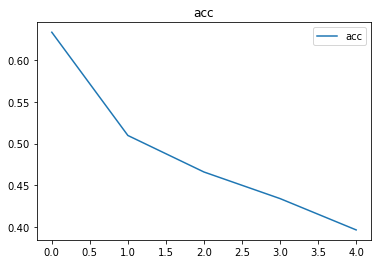

In [15]:
plt.plot(acc_,label="acc")
plt.title("acc")
plt.legend()
plt.show()

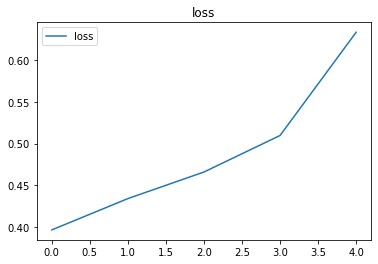

In [16]:
loss=acc_[::-1]
plt.plot(loss,label="loss")
plt.title("loss")
plt.legend()
plt.show()

In [17]:
print("loss")
print(loss)

loss
[0.39653882025367154, 0.43408546917629937, 0.4659475527540611, 0.5097320127661211, 0.6334634893131952]


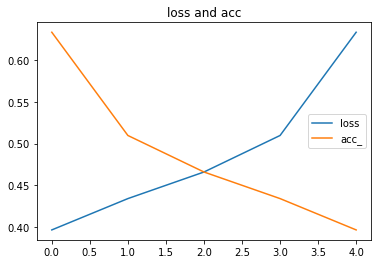

In [18]:
plt.plot(loss,label="loss")
plt.plot(acc_,label="acc_")
plt.title("loss and acc")
plt.legend()
plt.show()

Save our trained model to be deployed on the site later on.

In [19]:
torch.save(model.state_dict(), 'FreshnessDetector.pt')

In [20]:
model

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=512, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=2, bias=True)
)

Validating our model

In [21]:
def validate(model,train_loader,val_loader):
    for name, loader in [('train',train_loader),('val',validation_loader)]:
        correct = 0
        total = 0

        #gradients nor required, as we don't want to train our parameters
        with torch.no_grad():
            for imgs, labels in loader:
                imgs = imgs.to(device=device)
                labels = labels.to(device=device)
                outputs = model(imgs)
                #max_index,value
                _,predicted = torch.max(outputs,dim=1)
                total+=labels.shape[0]
                correct+=int((predicted==labels).sum())
    
        print('Accuracy {}: {:.2f}'.format(name, correct/total))

validate(model,train_loader,validation_loader)

Accuracy train: 0.83
Accuracy val: 0.81


Let's check one sample.

Actual: 1
Prediction: tensor([[-1.0476,  1.0347]], grad_fn=<AddmmBackward>)


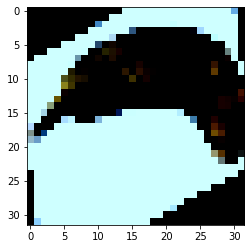

In [22]:
img,label = dataset[1]
plt.imshow(img.permute(1,2,0))
out = model(img.unsqueeze(0).to(device))
print('Actual: {}'.format(label))
print('Prediction: {}'.format(out))

# Evaluating our model
Apply the same transformation on the test dataset. 

In [23]:
transformations_test = transforms.Compose([
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.7369, 0.6360, 0.5318),
                                                           (0.3281, 0.3417, 0.3704))
                                      ])
test = FruitsDataset('/kaggle/input/fruits-fresh-and-rotten-for-classification/dataset/',subset='test',transforms=transformations_test)

The values sent to normalize are calculated using the code below.

In [24]:
# imgs = torch.stack([img for img,_ in tqdm_notebook(test)], dim=3)
# imgs.shape

# #Mean
# print(imgs.view(3,-1).mean(dim=1))

# #Standard Deviation
# print(imgs.view(3, -1).std(dim=1))

Prediction: tensor([[0.0213, 0.9787]], grad_fn=<SoftmaxBackward>)


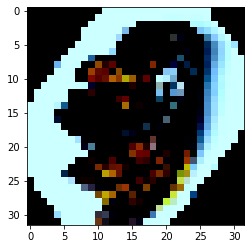

In [25]:
img,_ = test[400]
plt.imshow(img.permute(1,2,0))
s = nn.Softmax(dim=1)
out = s(model(img.unsqueeze(0).to(device)))
print('Prediction: {}'.format(out))

In [26]:
correct = 0
total = 0
test_loader = torch.utils.data.DataLoader(test, batch_size=batch_size)
for imgs, labels in train_loader:
    imgs = imgs.to(device=device)
    labels = labels.to(device=device)
    out = model(imgs)
    _,predicted = torch.max(out,dim=1)
    correct += int((predicted==labels).sum())
    total += len(labels)

Our final accuracy.

In [27]:
(correct/total)*100

83.07533539731682

###### (correct/total)*100